1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).

In [19]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [15]:
import pandas as pd
import numpy as np
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [54]:
df['cholesterol'].value_counts()

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64

In [6]:
#разделим данные на train/test
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline

In [11]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [12]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers + cat_transformers + base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

### Логистическая регрессия

In [16]:
from sklearn.linear_model import LogisticRegression

In [24]:
classifier_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_logreg, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_logreg.fit(X_train, y_train)
y_score_logreg = classifier_logreg.predict_proba(X_test)[:, 1]

CV score is 0.7867397811595499+-0.008587216885603979


Посчитаем precision/recall/f_score

In [32]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [25]:
b=1
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(y_test.values, y_score_logreg)
fscore_logreg = (1+b**2)*(precision_logreg * recall_logreg) / (b**2*precision_logreg + recall_logreg)
# locate the index of the largest f score
ix_logreg = np.argmax(fscore_logreg)
print('Best Threshold_logreg=%f, F-Score_logreg=%.3f, Precision_logreg=%.3f, Recall_logreg=%.3f' % (thresholds_logreg[ix_logreg], 
                                                                        fscore_logreg[ix_logreg],
                                                                        precision_logreg[ix_logreg],
                                                                        recall_logreg[ix_logreg]))

Best Threshold_logreg=0.386943, F-Score_logreg=0.730, Precision_logreg=0.647, Recall_logreg=0.837


In [27]:
#вычислим roc-auc
roc_auc_score_logreg = roc_auc_score(y_true=y_test, y_score=y_score_logreg)
print("roc auc score_logreg: {}".format(roc_auc_score_logreg))

roc auc score_logreg: 0.7840286921220101


построим confusion_matrix

In [48]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4862 3958]
 [1412 7268]]


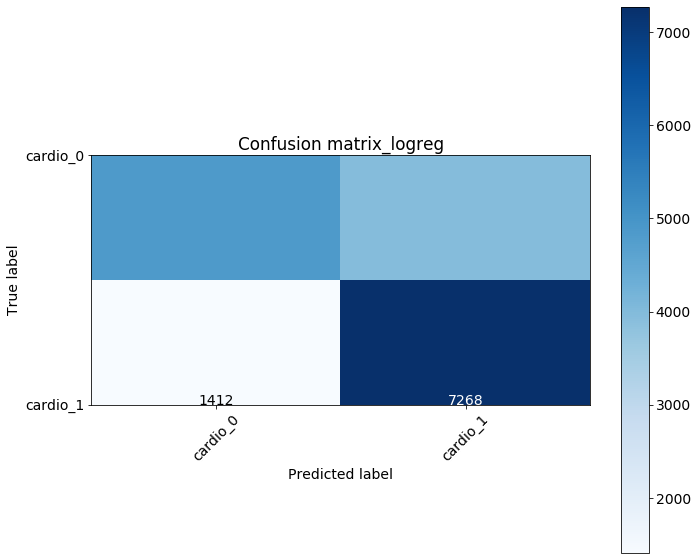

In [49]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 14}

plt.rc('font', **font)

cnf_matrix_logreg = confusion_matrix(y_test, y_score_logreg>thresholds_logreg[ix_logreg])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_logreg, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_logreg')
plt.savefig("conf_matrix_logreg.png")
plt.show()

### Cлучайный лес

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [59]:

classifier_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=5, random_state = 42)),
])

In [60]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_rf, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_rf.fit(X_train, y_train)
y_score_rf = classifier_rf.predict_proba(X_test)[:, 1]

CV score is 0.792751413469867+-0.0071097597142048075


Посчитаем precision/recall/f_score

In [61]:
b=1
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_rf)
fscore_rf = (1+b**2)*(precision_rf * recall_rf) / (b**2*precision_rf + recall_rf)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
print('Best Threshold_rf=%f, F-Score_rf=%.3f, Precision_rf=%.3f, Recall_rf=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

Best Threshold_rf=0.393273, F-Score_rf=0.736, Precision_rf=0.677, Recall_rf=0.806


In [62]:
#вычислим roc-auc
roc_auc_score_rf = roc_auc_score(y_true=y_test, y_score=y_score_rf)
print("roc auc score_rf: {}".format(roc_auc_score_rf))

roc auc score_rf: 0.7937052624429187


построим confusion_matrix

Confusion matrix, without normalization
[[5482 3338]
 [1687 6993]]


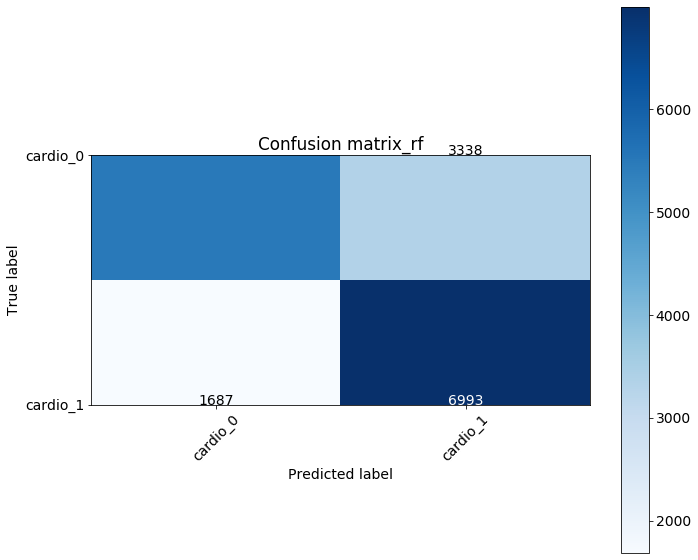

In [64]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 14}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, y_score_rf>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_rf')
plt.savefig("conf_matrix_rf.png")
plt.show()

### Lightgbm

In [66]:
import sys
!{sys.executable} -m pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org lightgbm

In [67]:
from lightgbm import LGBMClassifier

In [68]:
classifier_lgbm = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(max_depth=5, random_state = 42)),
])

In [69]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_lgbm, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_lgbm.fit(X_train, y_train)
y_score_lgbm = classifier_lgbm.predict_proba(X_test)[:, 1]

CV score is 0.803119127728178+-0.006789246161152004


Посчитаем precision/recall/f_score

In [70]:
b=1
precision_lgbm, recall_lgbm, thresholds_lgbm = precision_recall_curve(y_test.values, y_score_lgbm)
fscore_lgbm = (1+b**2)*(precision_lgbm * recall_lgbm) / (b**2*precision_lgbm + recall_lgbm)
# locate the index of the largest f score
ix_lgbm = np.argmax(fscore_lgbm)
print('Best Threshold__lgbm=%f, F-Score_lgbm=%.3f, Precision_lgbm=%.3f, Recall_lgbm=%.3f' % (thresholds_lgbm[ix_lgbm], 
                                                                        fscore_lgbm[ix_lgbm],
                                                                        precision_lgbm[ix_lgbm],
                                                                        recall_lgbm[ix_lgbm]))

Best Threshold__lgbm=0.342903, F-Score_lgbm=0.739, Precision_lgbm=0.660, Recall_lgbm=0.840


In [71]:
#вычислим roc-auc
roc_auc_score_lgbm = roc_auc_score(y_true=y_test, y_score=y_score_lgbm)
print("roc auc score_lgbm: {}".format(roc_auc_score_lgbm))

roc auc score_lgbm: 0.802354828260029


построим confusion_matrix

Confusion matrix, without normalization
[[5063 3757]
 [1387 7293]]


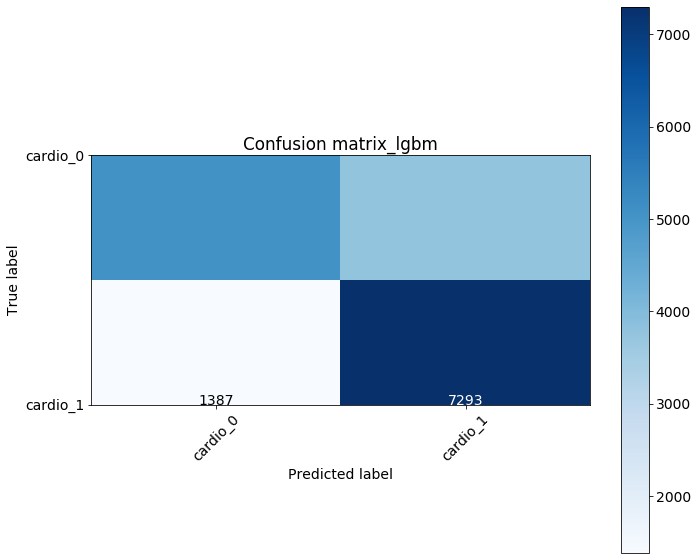

In [72]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 14}

plt.rc('font', **font)

cnf_matrix_lgbm = confusion_matrix(y_test, y_score_lgbm>thresholds_lgbm[ix_lgbm])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_lgbm, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix_lgbm')
plt.savefig("conf_matrix_lgbm.png")
plt.show()

Построим матрицу метрик

In [74]:
df = pd.DataFrame({'Precision' : [precision_logreg[ix_logreg], precision_rf[ix_rf], precision_lgbm[ix_lgbm]],
                   'Recall' : [recall_logreg[ix_logreg], recall_rf[ix_rf], recall_lgbm[ix_lgbm]],
                   'roc auc score' : [roc_auc_score_logreg, roc_auc_score_rf, roc_auc_score_lgbm],
                   'F-score' : [fscore_logreg[ix_logreg], fscore_rf[ix_rf], fscore_lgbm[ix_lgbm]] 
                   
                  })
df.index = ['LogReg', 'RandomForest', 'LightGBM']
df.round(3)

,Precision,Recall,roc auc score,F-score
LogReg,0.647,0.837,0.784,0.730
RandomForest,0.677,0.806,0.794,0.736
LightGBM,0.660,0.840,0.802,0.739


In [ ]:
#Вывод: лучший результат показала модель градиентного бустинга, но если бы для нас важнен был precision, 
#то лучшая модель - это Random Forest.

5. (опциональный вопрос) какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [2]:
#рассмотрим первую модель
tp = 90
fp = 10
tn = 99890
fn = 10

precision = tp/(tp+fp)
recall = tp/(tp+fn)
FPR = fp / (fp + tn)

print("Recall = TPR: {}".format(recall))
print("FPR: {}".format(FPR))
print("Precision: {}".format(precision))


Recall = TPR: 0.9
FPR: 0.0001001001001001001
Precision: 0.9


In [3]:
#рассмотрим вторую модель
tp = 90
fp = 910
tn = 98990
fn = 10

precision = tp/(tp+fp)
recall = tp/(tp+fn)
FPR = fp / (fp + tn)

print("Recall = TPR: {}".format(recall))
print("FPR: {}".format(FPR))
print("Precision: {}".format(precision))

Recall = TPR: 0.9
FPR: 0.00910910910910911
Precision: 0.09


In [4]:
#Если мы опираемся на roc-auc curve, то есть рассматриваем TPR и FPR, то обе модели хорошие, 
#но если мы будем рассматривать precision_recall curve, то вторая модель будет не такой хорошей. То есть roc-auc curve 
#может показывать неадекватную оценку на несбалансированных выборках, так как измеряет долю ложноположительного класса
#из всех объектов отрицательного класса.